The purpose of this script is to train a propensity score model for each player.

More specifically, every player will have an associated model. This model will predict the probability of the player's presence in a stint, given covariates.
This is the "Propensity Score" of the player, and is the foundation of the causal inference portion of this project.

For each player, train a model that uses the following features
 - Score margin at the beginning of the stint
 - Minutes remaining at the beginning of the stint
 - Defensive team strength (defined as cumulative sum of a box score statistics)

The target will be an indicator: 1 if player is present in the stint, 0 otherwise.

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nba_on_court as noc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

# Preparing the Data

We need to infer each of the above metrics before model training can begin.

In [3]:
data: pd.DataFrame             = pd.read_csv('../../data/nba_2223_season_stints.csv', dtype={'game_id': str})
plr_id_to_name: dict[str, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
plr_name_to_id: dict[str, str] = dict((v,k) for k,v in plr_id_to_name.items())
box_scores: pd.DataFrame       = pd.read_csv('../../data/nba_2223_box_stats.csv')
design: pd.DataFrame           = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz') \
                                   .drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)

In [7]:
# remove accents from player names,
# and add player ID to the box score data
import unicodedata

def strip_accents(s):
   '''
   Credit to https://stackoverflow.com/a/518232
   '''
   return ''.join(c for c in unicodedata.normalize('NFD', s) 
                  if unicodedata.category(c) != 'Mn')

box_scores['Player']   = box_scores['Player'].apply(strip_accents)
box_scores['PlayerID'] = box_scores['Player'].apply(lambda name: str(plr_name_to_id[name])) # casting to str for lexicographic sorting

box_scores.to_csv('../../data/nba_2223_box_stats.csv', index=False)

In [8]:
# players that swapped teams have multiple entries
# total stats is always first
box_scores.drop_duplicates('Player', keep='first', inplace=True) 

box_scores

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional,PlayerID
0,1,Precious Achiuwa,C,23,TOR,55,1140,15.2,0.554,0.267,0.307,9.3,24.4,16.3,6.3,1.3,2.6,11.4,19.4,0.8,1.4,2.2,0.093,-1.4,-0.8,-2.3,-0.1,achiupr01,1630173
1,2,Steven Adams,C,29,MEM,42,1133,17.5,0.564,0.004,0.490,20.1,25.3,22.7,11.2,1.5,3.7,19.8,14.6,1.3,2.1,3.4,0.144,-0.3,0.9,0.6,0.7,adamsst01,203500
2,3,Bam Adebayo,C,25,MIA,75,2598,20.1,0.592,0.011,0.361,8.0,23.6,15.5,15.9,1.7,2.4,12.7,25.2,3.6,3.8,7.4,0.137,0.8,0.8,1.5,2.3,adebaba01,1628389
3,4,Ochai Agbaji,SG,22,UTA,59,1209,9.5,0.561,0.591,0.179,3.9,6.9,5.4,7.5,0.6,1.0,9.0,15.8,0.9,0.4,1.3,0.053,-1.7,-1.4,-3.0,-0.3,agbajoc01,1630534
4,5,Santi Aldama,PF,22,MEM,77,1682,13.9,0.591,0.507,0.274,5.4,18.0,11.7,7.6,1.3,2.6,9.3,16.0,2.1,2.4,4.6,0.130,-0.3,0.8,0.5,1.1,aldamsa01,1630583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,54,795,14.1,0.573,0.172,0.131,9.4,14.6,11.8,12.9,3.4,0.6,16.7,13.5,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4,youngth01,201152
675,536,Trae Young,PG,24,ATL,73,2541,22.0,0.573,0.331,0.460,2.4,7.0,4.7,42.5,1.5,0.3,15.2,32.6,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4,youngtr01,1629027
676,537,Omer Yurtseven,C,24,MIA,9,83,16.7,0.675,0.259,0.222,10.9,21.9,16.2,3.9,1.2,2.5,11.9,18.0,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0,yurtsom01,1630209
677,538,Cody Zeller,C,30,MIA,15,217,16.4,0.659,0.034,0.593,13.0,21.8,17.3,7.2,0.7,1.9,15.8,18.1,0.4,0.3,0.7,0.147,-2.0,-0.7,-2.8,0.0,zelleco01,203469


In [9]:
# infer home strength and away strength
# careful with the axes. the player IDs are sorted lexicographically, not numerically
home_indicators = design.replace(-1, 0).sort_index(axis=1)
away_indicators = design.replace(1, 0).mul(-1).sort_index(axis=1)
bpm             = box_scores.sort_values('PlayerID')['BPM'].astype(float).to_numpy()

data['home_strength'] = home_indicators.mul(bpm, axis=1).sum(axis=1)
data['away_strength'] = away_indicators.mul(bpm, axis=1).sum(axis=1)

In [10]:
data

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,home_strength,away_strength
0,0022200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,9.6,10.0
1,0022200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,9.6,11.9
2,0022200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,8.0,11.9
3,0022200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,8.0,8.2
4,0022200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,1.1,8.2
...,...,...,...,...,...,...,...,...,...,...,...
32379,0022201229,18,203082_1627814_1629647_1630240_1630688,201566_203486_1626181_1629611_1630538,16,8,13,3.44,-31.250000,-7.8,1.7
32380,0022201229,19,203082_1627814_1629006_1629647_1630240,201566_203486_1626181_1629611_1630538,11,7,10,2.45,-27.272727,-6.8,1.7
32381,0022201229,20,203082_1627814_1629006_1629647_1630240,201566_202695_203486_1626181_1629611,21,13,17,4.30,-19.047619,-6.8,8.6
32382,0022201229,21,203082_1627814_1629006_1629647_1630240,201566_201587_202695_203486_1626181,12,7,8,3.53,-8.333333,-6.8,9.3


In [11]:
# infer start score margin and start time left
games: pd.Series         = pd.unique(data['game_id'])
data['end_score_margin'] = data['home_points'] - data['away_points']


list_of_data = []
for game_id in games:
    game_data: pd.DataFrame = data[data['game_id'] == game_id]

    game_data['start_score_margin'] = game_data['end_score_margin'].shift(fill_value=0)

    time_elapsed = game_data['minutes'].cumsum()
    game_data['start_time_left'] = 48 - time_elapsed.shift(fill_value=0)
    game_data['end_time_left']   = 48 - time_elapsed

    list_of_data.append(game_data)

data = pd.concat(list_of_data)

data
    

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,home_strength,away_strength,end_score_margin,start_score_margin,start_time_left,end_time_left
0,0022200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,9.6,10.0,3,0,48.00,45.30
1,0022200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,9.6,11.9,4,3,45.30,43.63
2,0022200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,8.0,11.9,-3,4,43.63,43.15
3,0022200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,8.0,8.2,4,-3,43.15,42.37
4,0022200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,1.1,8.2,-3,4,42.37,40.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32379,0022201229,18,203082_1627814_1629647_1630240_1630688,201566_203486_1626181_1629611_1630538,16,8,13,3.44,-31.250000,-7.8,1.7,-5,1,15.09,11.65
32380,0022201229,19,203082_1627814_1629006_1629647_1630240,201566_203486_1626181_1629611_1630538,11,7,10,2.45,-27.272727,-6.8,1.7,-3,-5,11.65,9.20
32381,0022201229,20,203082_1627814_1629006_1629647_1630240,201566_202695_203486_1626181_1629611,21,13,17,4.30,-19.047619,-6.8,8.6,-4,-3,9.20,4.90
32382,0022201229,21,203082_1627814_1629006_1629647_1630240,201566_201587_202695_203486_1626181,12,7,8,3.53,-8.333333,-6.8,9.3,-1,-4,4.90,1.37


# Fit the Propensity Models

At this point, we must fit a propensity model for every player. The model will be a Random Forest.

Every player must be trained on stints where they *could* have been present, so filtering the data for each player is necessary. 
Since players can be apart of multiple teams, it is complicated to determine games they could've been a part of, as this requires determining
when the player swapped teams. **As such, the model is only trained on stints in a game where the player was on the court at least once.**

In [14]:
# it's necessary to determine games where the player was present at least once
#
# moreover, it's necessary to determine whether the player was on home/away,
# in order to appropriately adjust score margin.

# this solution basically replaces the design matrix. instead of being an indicator
# for presence in the stint, it will serve for an indicator of presence in the game.

plr_indicators_list = []
for game_id in games:
    bools: list[bool]     = data['game_id'] == game_id
    game_data, indicators = data[bools], design[bools]

    sign = np.sign(indicators.sum(axis=0))

    plr_indicators_list.append(
        indicators.replace(0, dict(zip(indicators.columns, sign)))
    )

game_presence = pd.concat(plr_indicators_list)

In [15]:
game_presence.head(50)

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [78]:
def train_player_model(
        plr_id: str, 
        *, 
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> RandomForestClassifier | tuple[RandomForestClassifier, pd.DataFrame, pd.Series]:
    '''
    Given a player ID, train a propensity model. 
    This is trained on the features `'start_score_margin', 'start_time_left', 'opponent_strength'` in that order.
    If `return_plr_data` is True, also return the data the model was trained on, and their targets.

    Each of the optional variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    # identify relevent stints
    bools: pd.Series[bool] = game_presence[plr_id].astype(bool)
    plr_data               = data[bools]
    game_presence          = game_presence.loc[bools, plr_id]

    # change the score margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero

    # extract target: 1 if on court, 0 otherwise.
    target = design.loc[bools, plr_id].abs()

    # to do: all the data is ready. train the model.
    model = RandomForestClassifier().fit(X=plr_data[['start_score_margin', 'start_time_left', 'opponent_strength']], y=target)

    if return_plr_data:
        return model, plr_data[['start_score_margin', 'start_time_left', 'opponent_strength']], target
    else:
        return model

In [80]:
prob_models: dict[str, tuple[RandomForestClassifier, pd.DataFrame, pd.Series]] = {
    plr_id: train_player_model(plr_id, return_plr_data=True)
    for plr_id in plr_id_to_name
}

# Extract Results

Now that all the propensity models are trained, we can extract information from them.

In [81]:
probs: dict[str, tuple[np.ndarray, float]] = { # probability that player is on court for their stint (not all stints are the same across players!) and accuracy of model
    plr_id: (
        model_stuff[0].predict_proba(model_stuff[1])[:, 1], 
        model_stuff[0].score(model_stuff[1], model_stuff[2]))
    for plr_id, model_stuff in prob_models.items()
}

In [87]:
accuracies = [item[1] for item in probs.values()]

print(
    f'Average: {np.mean(accuracies)}',
    f'Median: {np.median(accuracies)}',
    f'St. Dev.: {np.std(accuracies)}',
    f'Min: {np.min(accuracies)}',
    f'Max: {np.max(accuracies)}',
    sep='\n'
)

Average: 0.9988032308457954
Median: 0.9994212962962963
St. Dev.: 0.0015337257942866275
Min: 0.989010989010989
Max: 1.0


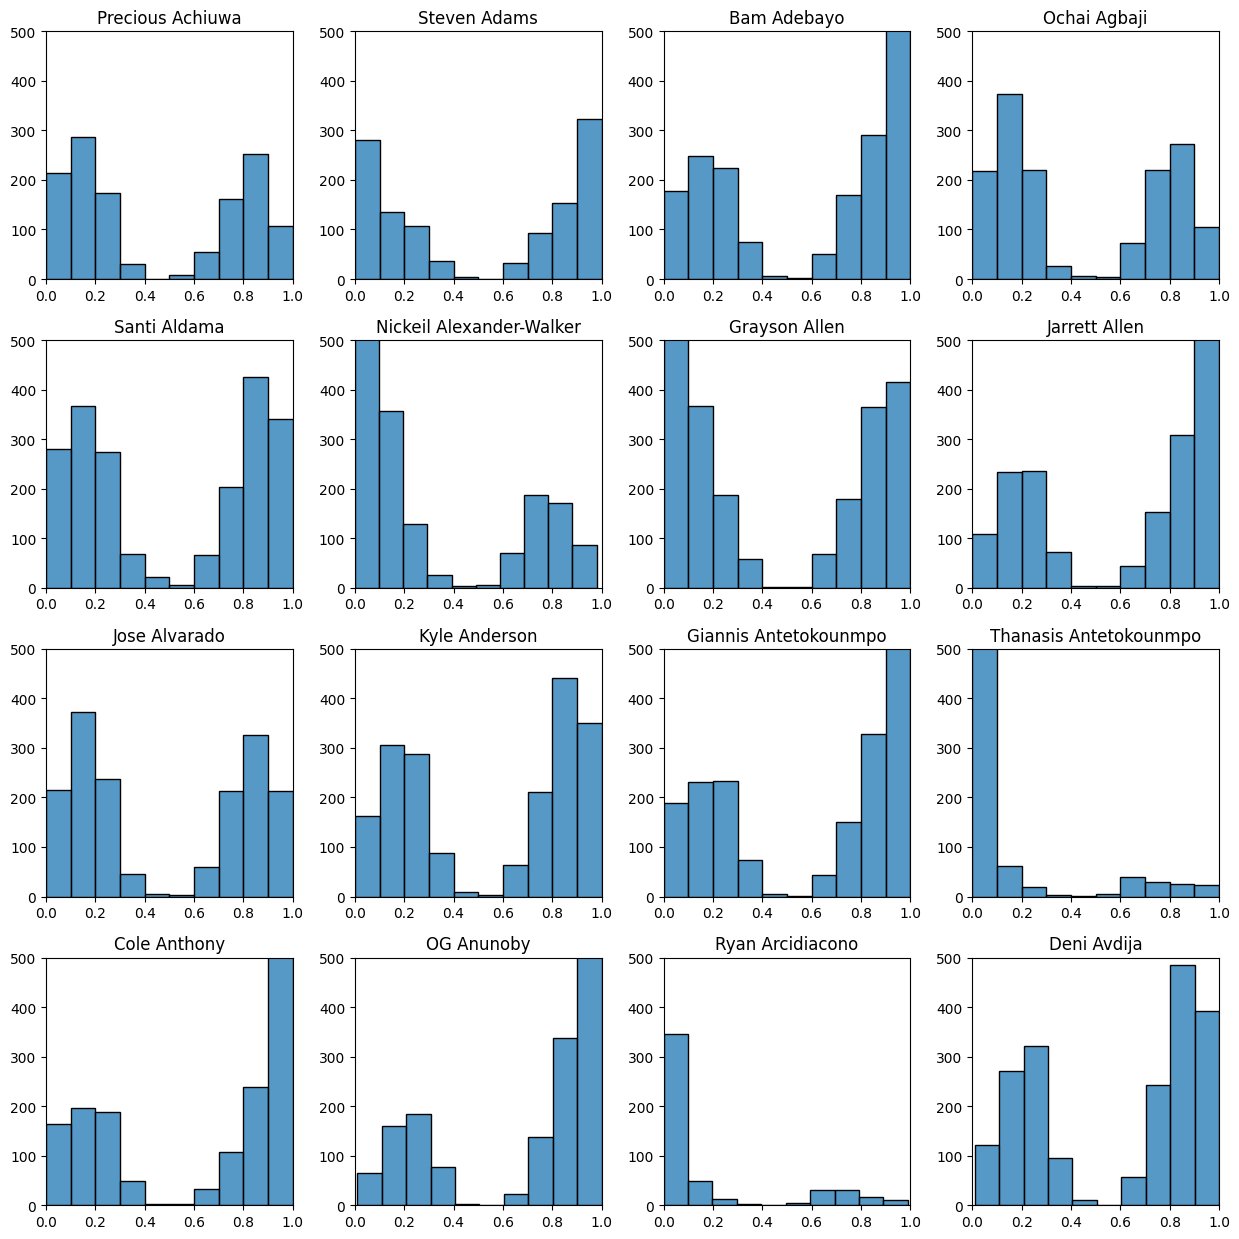

In [86]:
# make a collage
n = 4

fig, ax = plt.subplots(n,n, figsize=(12.5, 12.5))

plr_ids   = list(probs)
plr_probs = list(probs.values())

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id, plr_prob, plr_acc = plr_ids[k], plr_probs[k][0], plr_probs[k][1]

    graph = sns.histplot(plr_prob, bins=10, ax=ax[i, j])
    graph.set_xlim(0, 1)
    graph.set_ylim(0, 500)
    graph.set_ylabel('')
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()